In [1]:
import logging
import numpy as np
import os
import pickle
import copy
import random

from pathlib import Path

import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from fvcore.common.config import CfgNode

from naslib import utils
from naslib.search_spaces import SimpleCellSearchSpace
from naslib.defaults.trainer import Trainer
from naslib.utils.custom_dataset import CustomDataset
from naslib.optimizers import DARTSOptimizer, GDASOptimizer, RandomSearch
from naslib.search_spaces import NasBench301SearchSpace, SimpleCellSearchSpace
from naslib.utils import set_seed, setup_logger, get_config_from_args
from naslib.search_spaces.core.query_metrics import Metric
from naslib.search_spaces.core.graph import Graph
from naslib.search_spaces.nasbenchasr.primitives import ASRPrimitive, CellLayerNorm, Head, ops, PadConvReluNorm
from naslib.utils import get_project_root
from naslib.search_spaces.core import primitives as core_ops
from naslib.search_spaces.nasbenchasr.conversions import flatten, \
    copy_structure, make_compact_mutable, make_compact_immutable
from naslib.search_spaces.nasbenchasr.encodings import encode_asr
from naslib.utils.encodings import EncodingType
from naslib.utils.log import log_every_n_seconds, log_first_n
from naslib.search_spaces.core.primitives import AbstractPrimitive, Identity


In [2]:
datasets = Path('/home/data')

In [3]:
def transform_to_closest_square_shape(x):
    len_x = len(x)
    closest_square = int(np.round(np.sqrt(len_x)))
    if closest_square ** 2 < len_x: 
        closest_square += 1
    x = np.pad(x, (0, closest_square  ** 2 - len_x))
    return x.reshape((1, closest_square, closest_square))

class TabNasTorchDataset(Dataset):
    def __init__(self, root_dir, name, queue, norm='min_max'):
        super().__init__()
        
        bin_exists = False
        num_exists = False
        
        assert queue in ['train', 'test', 'val']

        self.root_dir = root_dir 
        self.name = name
        self.type = queue

        x_num = f'X_num_{queue}.npy'
        x_bin = f'X_bin_{queue}.npy'
        y = f'Y_{queue}.npy'
        
        
        if (root_dir / name/ x_bin).exists():
            bin_exists = True
            
        if (root_dir / name/ x_num).exists():
            num_exists = True
        
        self.y = np.load(root_dir / name / y)
        
        if num_exists:
            x_num = np.load(root_dir / name / x_num)
            x_num = (x_num - np.min(x_num, axis=0)) / (np.max(x_num, axis=0) - np.min(x_num, axis=0))
        
        if bin_exists:
            x_bin = np.load(root_dir / name / x_bin)
        
        if num_exists and bin_exists:
            self.x = np.concatenate((x_num, x_bin), axis=1)
        elif num_exists:
            self.x = x_num
        elif bin_exists:
            self.x = x_bin
        else:
            raise NotImplementedError
            
        self.num_features = self.x.shape[1]
        self.num_classes = int(np.max(self.y)) + 1
            
    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]

        return  x, y.astype(np.int64)
        
    def __len__(self):
        return len(self.x)
    



In [4]:
with open('/home/table_nas/darts_cell.yaml') as f:
    config = CfgNode.load_cfg(f)

In [5]:
class TabNasDataset(CustomDataset):
    def __init__(self, config, ds_train, ds_test, mode='train'):
        super().__init__(config, mode)
        self.ds_train = ds_train
        self.ds_test = ds_test

    def get_transforms(self, config):
        return Compose([ToTensor()]), Compose([ToTensor()])


    def get_data(self, data, train_transform, valid_transform):
        train_data = self.ds_train
        test_data = self.ds_test

        return train_data, test_data
    


In [6]:
class TabNasTrainer(Trainer):
    def evaluate(
        self,
        retrain:bool=True,
        search_model:str="",
        resume_from:str="",
        best_arch:Graph=None,
        dataset_api:object=None,
        metric:Metric=None,
    ):
        """
        Evaluate the final architecture as given from the optimizer.

        If the search space has an interface to a benchmark then query that.
        Otherwise train as defined in the config.

        Args:
            retrain (bool)      : Reset the weights from the architecure search
            search_model (str)  : Path to checkpoint file that was created during search. If not provided,
                                  then try to load 'model_final.pth' from search
            resume_from (str)   : Resume retraining from the given checkpoint file.
            best_arch           : Parsed model you want to directly evaluate and ignore the final model
                                  from the optimizer.
            dataset_api         : Dataset API to use for querying model performance.
            metric              : Metric to query the benchmark for.
        """
        logger.info("Start evaluation")
        if not best_arch:

            if not search_model:
                search_model = os.path.join(
                    self.config.save, "search", "model_final.pth"
                )
            self._setup_checkpointers(search_model)  # required to load the architecture

            best_arch = self.optimizer.get_final_architecture()
        #logger.info(f"Final architecture hash: {best_arch.get_hash()}")

        if True:
            best_arch.to(self.device)
            if retrain:
                logger.info("Starting retraining from scratch")
                best_arch.reset_weights(inplace=True)

                (
                    self.train_queue,
                    self.valid_queue,
                    self.test_queue,
                ) = self.build_eval_dataloaders(self.config)

                optim = self.build_eval_optimizer(best_arch.parameters(), self.config)
                scheduler = self.build_eval_scheduler(optim, self.config)

                start_epoch = self._setup_checkpointers(
                    resume_from,
                    search=False,
                    period=self.config.evaluation.checkpoint_freq,
                    model=best_arch,  # checkpointables start here
                    optim=optim,
                    scheduler=scheduler,
                )

                grad_clip = self.config.evaluation.grad_clip
                loss = torch.nn.CrossEntropyLoss()

                self.train_top1.reset()
                self.train_top5.reset()
                self.val_top1.reset()
                self.val_top5.reset()

                # Enable drop path
                best_arch.update_edges(
                    update_func=lambda edge: edge.data.set(
                        "op", DropPathWrapper(edge.data.op)
                    ),
                    scope=best_arch.OPTIMIZER_SCOPE,
                    private_edge_data=True,
                )

                # train from scratch
                epochs = self.config.evaluation.epochs
                for e in range(start_epoch, epochs):
                    best_arch.train()

                    if torch.cuda.is_available():
                        log_first_n(
                            logging.INFO,
                            "cuda consumption\n {}".format(torch.cuda.memory_summary()),
                            n=20,
                        )

                    # update drop path probability
                    drop_path_prob = self.config.evaluation.drop_path_prob * e / epochs
                    best_arch.update_edges(
                        update_func=lambda edge: edge.data.set(
                            "drop_path_prob", drop_path_prob
                        ),
                        scope=best_arch.OPTIMIZER_SCOPE,
                        private_edge_data=True,
                    )

                    # Train queue
                    for i, (input_train, target_train) in enumerate(self.train_queue):
                        input_train = input_train.to(self.device)
                        target_train = target_train.to(self.device, non_blocking=True)

                        optim.zero_grad()
                        logits_train = best_arch(input_train)
                        train_loss = loss(logits_train, target_train)
                        if hasattr(
                            best_arch, "auxilary_logits"
                        ):  # darts specific stuff
                            log_first_n(logging.INFO, "Auxiliary is used", n=10)
                            auxiliary_loss = loss(
                                best_arch.auxilary_logits(), target_train
                            )
                            train_loss += (
                                self.config.evaluation.auxiliary_weight * auxiliary_loss
                            )
                        train_loss.backward()
                        if grad_clip:
                            torch.nn.utils.clip_grad_norm_(
                                best_arch.parameters(), grad_clip
                            )
                        optim.step()

                        self._store_accuracies(logits_train, target_train, "train")
                        log_every_n_seconds(
                            logging.INFO,
                            "Epoch {}-{}, Train loss: {:.5}, learning rate: {}".format(
                                e, i, train_loss, scheduler.get_last_lr()
                            ),
                            n=5,
                        )

                    # Validation queue
                    if self.valid_queue:
                        best_arch.eval()
                        for i, (input_valid, target_valid) in enumerate(
                            self.valid_queue
                        ):

                            input_valid = input_valid.to(self.device).float()
                            target_valid = target_valid.to(self.device).float()

                            # just log the validation accuracy
                            with torch.no_grad():
                                logits_valid = best_arch(input_valid)
                                self._store_accuracies(
                                    logits_valid, target_valid, "val"
                                )

                    scheduler.step()
                    self.periodic_checkpointer.step(e)
                    self._log_and_reset_accuracies(e)

            # Disable drop path
            best_arch.update_edges(
                update_func=lambda edge: edge.data.set(
                    "op", edge.data.op.get_embedded_ops()
                ),
                scope=best_arch.OPTIMIZER_SCOPE,
                private_edge_data=True,
            )

            # measure final test accuracy
            top1 = utils.AverageMeter()
            top5 = utils.AverageMeter()

            best_arch.eval()

            for i, data_test in enumerate(self.test_queue):
                input_test, target_test = data_test
                input_test = input_test.to(self.device)
                target_test = target_test.to(self.device, non_blocking=True)

                n = input_test.size(0)

                with torch.no_grad():
                    logits = best_arch(input_test)

                    prec1, prec5 = utils.accuracy(logits, target_test, topk=(1, 5))
                    top1.update(prec1.data.item(), n)
                    top5.update(prec5.data.item(), n)

                log_every_n_seconds(
                    logging.INFO,
                    "Inference batch {} of {}.".format(i, len(self.test_queue)),
                    n=5,
                )

            logger.info(
                "Evaluation finished. Test accuracies: top-1 = {:.5}, top-5 = {:.5}".format(
                    top1.avg, top5.avg
                )
            )

            return top1.avg
        
    @staticmethod
    def build_search_dataloaders(config):
        return train_queue, valid_queue, _
     
    @staticmethod
    def build_eval_dataloaders(config):
        return train_queue, valid_queue, test_queue

In [7]:
name = 'covtype'
ds_train = TabNasTorchDataset(datasets, name, 'train')
ds_test = TabNasTorchDataset(datasets, name, 'test')

NUM_FEATURES = ds_train.num_features
NUM_CLASSES = ds_train.num_classes
print(NUM_FEATURES, NUM_CLASSES)

54 7


In [8]:
ds_train.y.max()

6

In [9]:


OP_NAMES = ['linear', 'zero', 'resblock']
class Head(ASRPrimitive):

    def __init__(self, filters, num_classes):
        super().__init__(locals())
        self.layers = nn.ModuleList([
            nn.Linear(in_features=filters, out_features=num_classes)
        ])

    def forward(self, x, edge_data=None):
        output = self.layers[0](x)
        output = nn.functional.relu(output)
        return output
    
class TransformerOP(ASRPrimitive):

    def __init__(self, filters):
        super().__init__(locals())
        self.bn1 = nn.BatchNorm1d(filters)
        self.bn2 = nn.BatchNorm1d(filters)
        self.mha = nn.MultiheadAttention(filters, filters // 4, batch_first=True)
        self.ff = nn.Linear(filters, filters)
        
    def forward(self, x, edge_data=None):
        out = self.bn1(x)
        out, _ = self.mha(x, x, x, need_weights=False)
        out = x + out 
        
        out2 = self.bn2(out)
        out2 = self.ff(out2)
        return out2 + out
    
class DropPathWrapper(AbstractPrimitive):
    """
    A wrapper for the drop path training regularization.
    """

    def __init__(self, op):
        super().__init__(locals())
        self.op = op
        self.device = DEVICE

    def forward(self, x, edge_data):
        x = self.op(x, edge_data)
        if (
            edge_data.drop_path_prob > 0.0
            and not isinstance(self.op, Identity)
            and self.training
        ):
            keep_prob = 1.0 - edge_data.drop_path_prob
            mask = torch.FloatTensor(x.size(0), 1).bernoulli_(keep_prob)
            mask = mask.to(self.device)
            x.div_(keep_prob)
            x.mul_(mask)
        return x

    def get_embedded_ops(self):
        return self.op
class LinearOP(ASRPrimitive):
    def __init__(self, in_features, out_features, dropout_rate=0, name='Linear'):
        super().__init__(locals())
        self.name = name

        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=DROPOUT_RATE)

    def forward(self, x, edge_data=None):
        x = self.linear(x)
        x = self.relu(x)
        x = torch.clamp_max_(x, 20)
        x = self.dropout(x)
        return x

    def __repr__(self):
        return f'{self.__class__}({self.linear})'
    
class ResBlockLinear(ASRPrimitive):
    def __init__(self, features, dropout_rate=0, name='resblock'):
        super().__init__(locals())
        self.name = name
        
        self.bn = nn.BatchNorm1d(features)
        self.linear1 = nn.Linear(features, features)
        self.relu = nn.ReLU(inplace=False)
        
        self.dropout1 = nn.Dropout(p=DROPOUT_RATE)
        self.dropout2 = nn.Dropout(p=DROPOUT_RATE)

        self.linear2 = nn.Linear(features, features)

        
    def forward(self, x, edge_data=None):
        out = self.bn(x)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = torch.clamp_max_(out, 20)

        out = self.dropout2(out)
        
        return x + out

    def __repr__(self):
        return f'{self.__class__}({self.linear2})'

class TabNasSearchSpace(Graph):
    """
    Contains the interface to the tabular benchmark of nas-bench-asr.
    Note: currently we do not support building a naslib object for
    nas-bench-asr architectures.
    """

    QUERYABLE = True
    OPTIMIZER_SCOPE = [
        'cells_stage_1',
        'cells_stage_2',
        'cells_stage_3',
        'cells_stage_4'
    ]

    def __init__(self):
        super().__init__()
        self.load_labeled = False
        self.max_epoch = 40
        self.max_nodes = 3
        self.accs = None
        self.compact = None

        self.n_blocks = NUM_BLOCKS
        self.n_cells_per_block = [1] * NUM_BLOCKS
        self.features = NUM_FEATURES
        self.filters = [NUM_FILTERS] * NUM_BLOCKS

        self.num_classes = NUM_CLASSES
        self.dropout_rate = 0.0
        self.use_norm = True

        self._create_macro_graph()

    def _create_macro_graph(self):
        cell = self._create_cell()

        # Macrograph defintion
        n_nodes = self.n_blocks + 2
        self.add_nodes_from(range(1, n_nodes + 1))

        for node in range(1, n_nodes):
            self.add_edge(node, node + 1)

        # Create the cell blocks and add them as subgraphs of nodes 2 ... 5
        for idx, node in enumerate(range(2, 2 + self.n_blocks)):
            scope = f'cells_stage_{idx + 1}'
            cells_block = self._create_cells_block(cell, n=self.n_cells_per_block[idx], scope=scope)
            self.nodes[node]['subgraph'] = cells_block.set_input([node - 1])

            # Assign the list of operations to the cell edges
            cells_block.update_edges(
                update_func=lambda edge: _set_cell_edge_ops(edge, filters=self.filters[idx], use_norm=self.use_norm),
                scope=scope,
                private_edge_data=True
            )

        start_node = 1
        for idx, node in enumerate(range(start_node, start_node + self.n_blocks)):
            if node == start_node:
                op = LinearOP(self.features, self.filters[0])
            else:
                op = core_ops.Identity()

            self.edges[node, node + 1].set('op', op)
        # Assign the LSTM + Linear layer to the last edge in the macro graph
        self.edges[self.n_blocks + 1, self.n_blocks + 2].set('op', Head(self.filters[0], self.num_classes))

    def _create_cells_block(self, cell, n, scope):
        block = Graph()
        block.name = f'{n}_cells_block'

        block.add_nodes_from(range(1, n + 2))

        for node in range(2, n + 2):
            block.add_node(node, subgraph=cell.copy().set_scope(scope).set_input([node - 1]))

        for node in range(1, n + 2):
            block.add_edge(node, node + 1)

        return block

    def _create_cell(self):
        normal_cell = Graph()
        normal_cell.name = "cell"    # Use the same name for all cells with shared attributes

        # Input nodes
        normal_cell.add_node(1)
        normal_cell.add_node(2)

        # Intermediate nodes
        normal_cell.add_node(3)
        normal_cell.add_node(4)
        normal_cell.add_node(5)
        normal_cell.add_node(6)

        # Output node
        normal_cell.add_node(7)

        # Edges
        for i in range(2, 7):
            normal_cell.add_edge(1, i)   # input 1
            #normal_cell.add_edge(2, i)
            normal_cell.add_edge(i, 7)
    
        normal_cell.add_edges_from([(3, 4), (3, 5), (3, 6)])
        normal_cell.add_edges_from([(4, 5), (4, 6)])
        normal_cell.add_edges_from([(5, 6)])

        # Edges connecting to the output are always the identity
        
        return normal_cell

    def query(self, metric=None, dataset=None, path=None, epoch=-1,
              full_lc=False, dataset_api=None):
        """
        Query results from nas-bench-asr
        """
        metric_to_asr = {
            Metric.VAL_ACCURACY: "val_per",
            Metric.TEST_ACCURACY: "test_per",
            Metric.PARAMETERS: "params",
            Metric.FLOPS: "flops",
        }

        assert self.compact is not None
        assert metric in [
            Metric.TRAIN_ACCURACY,
            Metric.TRAIN_LOSS,
            Metric.VAL_ACCURACY,
            Metric.TEST_ACCURACY,
            Metric.PARAMETERS,
            Metric.FLOPS,
            Metric.TRAIN_TIME,
            Metric.RAW,
        ]
        query_results = dataset_api["asr_data"].full_info(self.compact)

        if metric != Metric.VAL_ACCURACY:
            if metric == Metric.TEST_ACCURACY:
                return query_results[metric_to_asr[metric]]
            elif (metric == Metric.PARAMETERS) or (metric == Metric.FLOPS):
                return query_results['info'][metric_to_asr[metric]]
            elif metric in [Metric.TRAIN_ACCURACY, Metric.TRAIN_LOSS,
                            Metric.TRAIN_TIME, Metric.RAW]:
                return -1
        else:
            if full_lc and epoch == -1:
                return [
                    loss for loss in query_results[metric_to_asr[metric]]
                ]
            elif full_lc and epoch != -1:
                return [
                    loss for loss in query_results[metric_to_asr[metric]][:epoch]
                ]
            else:
                # return the value of the metric only at the specified epoch
                return float(query_results[metric_to_asr[metric]][epoch])

    def get_compact(self):
        assert self.compact is not None
        return self.compact

    def get_hash(self):
        return self.get_compact()

    def set_compact(self, compact):
        self.compact = make_compact_immutable(compact)

    def sample_random_architecture(self, dataset_api):
        search_space = [[len(OP_NAMES)] + [2] * (idx + 1) for idx in
                        range(self.max_nodes)]
        flat = flatten(search_space)
        m = [random.randrange(opts) for opts in flat]
        m = copy_structure(m, search_space)

        compact = m
        self.set_compact(compact)
        return compact

    def mutate(self, parent, mutation_rate=1, dataset_api=None):
        """
        This will mutate the cell in one of two ways:
        change an edge; change an op.
        Todo: mutate by adding/removing nodes.
        Todo: mutate the list of hidden nodes.
        Todo: edges between initial hidden nodes are not mutated.
        """
        parent_compact = parent.get_compact()
        parent_compact = make_compact_mutable(parent_compact)
        compact = copy.deepcopy(parent_compact)

        for _ in range(int(mutation_rate)):
            mutation_type = np.random.choice([2])

            if mutation_type == 1:
                # change an edge
                # first pick up a node
                node_id = np.random.choice(3)
                node = compact[node_id]
                # pick up an edge id
                edge_id = np.random.choice(len(node[1:])) + 1
                # edge ops are in [identity, zero] ([0, 1])
                new_edge_op = int(not compact[node_id][edge_id])
                # apply the mutation
                compact[node_id][edge_id] = new_edge_op

            elif mutation_type == 2:
                # change an op
                node_id = np.random.choice(3)
                node = compact[node_id]
                op_id = node[0]
                list_of_ops_ids = list(range(len(OP_NAMES)))
                list_of_ops_ids.remove(op_id)
                new_op_id = random.choice(list_of_ops_ids)
                compact[node_id][0] = new_op_id

        self.set_compact(compact)

    def get_nbhd(self, dataset_api=None):
        """
        Return all neighbors of the architecture
        """
        compact = self.get_compact()
        # edges, ops, hiddens = compact
        nbhd = []

        def add_to_nbhd(new_compact, nbhd):
            print(new_compact)
            nbr = NasBenchASRSearchSpace()
            nbr.set_compact(new_compact)
            nbr_model = torch.nn.Module()
            nbr_model.arch = nbr
            nbhd.append(nbr_model)
            return nbhd

        for node_id in range(len(compact)):
            node = compact[node_id]
            for edge_id in range(len(node)):
                if edge_id == 0:
                    edge_op = compact[node_id][0]
                    list_of_ops_ids = list(range(len(OP_NAMES)))
                    list_of_ops_ids.remove(edge_op)
                    for op_id in list_of_ops_ids:
                        new_compact = copy.deepcopy(compact)
                        new_compact = make_compact_mutable(new_compact)
                        new_compact[node_id][0] = op_id
                        nbhd = add_to_nbhd(new_compact, nbhd)
                else:
                    edge_op = compact[node_id][edge_id]
                    new_edge_op = int(not edge_op)
                    new_compact = copy.deepcopy(compact)
                    new_compact = make_compact_mutable(new_compact)
                    new_compact[node_id][edge_id] = new_edge_op
                    nbhd = add_to_nbhd(new_compact, nbhd)

        random.shuffle(nbhd)
        return nbhd

    def get_type(self):
        return 'asr'

    def get_max_epochs(self):
        return 39

    def encode(self, encoding_type=EncodingType.ADJACENCY_ONE_HOT):
        return encode_asr(self, encoding_type=encoding_type)


def _set_cell_edge_ops(edge, filters, use_norm):
    if use_norm and edge.head == 7:
        edge.data.set('op', core_ops.Identity())
        edge.data.finalize()
    elif edge.head % 2 == 0:  # Edge from intermediate node
        edge.data.set(
            'op', [
                LinearOP(filters, filters),
                ops['zero'](filters, filters),
                ResBlockLinear(filters),
                #TransformerOP(filters)
            ]
        )
    elif edge.tail % 2 == 0:  # Edge to intermediate node. Should always be Identity.
        edge.data.finalize()
    else:
        edge.data.set(
            'op',
            [
                core_ops.Zero(stride=1),
                core_ops.Identity()
            ]
        )

In [ ]:
from naslib.optimizers import DARTSOptimizer #+
from naslib.optimizers import GSparseOptimizer
from naslib.optimizers import OneShotNASOptimizer #+
from naslib.optimizers import RandomNASOptimizer
from naslib.optimizers import GDASOptimizer #+
from naslib.optimizers import DrNASOptimizer #+
from naslib.optimizers import RandomSearch
from naslib.optimizers import RegularizedEvolution
from naslib.optimizers import LocalSearch
from naslib.optimizers import Bananas
from naslib.optimizers import BasePredictor
from naslib.optimizers import Npenas
name = 'covtype'
DROPOUT_RATE = 0.
NUM_FILTERS = 16
DEVICE = 'cuda:1'
NUM_BLOCKS = 4
ds_train = TabNasTorchDataset(datasets, name, 'train')
ds_test = TabNasTorchDataset(datasets, name, 'test')

dataset = TabNasDataset(config, ds_train, ds_test)

train_queue, valid_queue, test_queue, train_transform, valid_transform = dataset.get_loaders()
    
search_space = TabNasSearchSpace()
logger = setup_logger(config.save + "/darts_new_new.log")
logger.setLevel(logging.INFO)  

optimizer = DARTSOptimizer(**config)
optimizer.device = DEVICE
optimizer.adapt_search_space(search_space, config.dataset)


trainer = TabNasTrainer(optimizer, config)
trainer.device = DEVICE

trainer.search()  # Search for an architecture
trainer.evaluate()  # Evaluate the best architecture

[05/27 08:56:37 nl.defaults.trainer]: Beginning search
[05/27 08:56:37 nl.optimizers.oneshot.darts.optimizer]: Arch weights (alphas, last column argmax): 
-0.000223, -0.001481, 0
+0.001136, -0.000868, 0
-0.001103, -0.000543, -0.001024, 1
+0.001060, +0.000482, 0
-0.000106, +0.000691, 1
+0.001744, +0.000882, -0.001240, 0
-0.000954, +0.001565, -0.001069, 1
-0.000161, -0.002817, -0.001053, 0
+0.000136, +0.001057, 1
+0.001010, +0.000249, +0.000647, 0
[05/27 08:56:38 nl.defaults.trainer]: Epoch 0-0, Train loss: 9.43743, validation loss: 9.04373, learning rate: [0.025]
[05/27 08:56:43 nl.defaults.trainer]: Epoch 0-21, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.025]
[05/27 08:56:48 nl.defaults.trainer]: Epoch 0-42, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.025]
[05/27 08:56:53 nl.defaults.trainer]: Epoch 0-63, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.025]
[05/27 08:56:58 nl.defaults.trainer]: Epoch 0-85, Train loss: 1.94591, 

[05/27 08:58:46 nl.defaults.trainer]: Epoch 3-29, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:58:51 nl.defaults.trainer]: Epoch 3-48, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:58:56 nl.defaults.trainer]: Epoch 3-68, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:59:01 nl.defaults.trainer]: Epoch 3-88, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:59:06 nl.defaults.trainer]: Epoch 3-108, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:59:11 nl.defaults.trainer]: Epoch 3-126, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:59:16 nl.defaults.trainer]: Epoch 3-144, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02494474645930835]
[05/27 08:59:22 nl.defaults.trainer]: Epoch 3-163, Train lo

[05/27 09:01:04 nl.defaults.trainer]: Epoch 6-64, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:09 nl.defaults.trainer]: Epoch 6-84, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:14 nl.defaults.trainer]: Epoch 6-102, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:19 nl.defaults.trainer]: Epoch 6-118, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:25 nl.defaults.trainer]: Epoch 6-140, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:30 nl.defaults.trainer]: Epoch 6-158, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02477947627157218]
[05/27 09:01:31 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0007, -0.0024], device='cuda:1', requires_grad=True), Parameter co

[05/27 09:03:24 nl.defaults.trainer]: Epoch 9-69, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.024505656386677944]
[05/27 09:03:29 nl.defaults.trainer]: Epoch 9-90, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.024505656386677944]
[05/27 09:03:34 nl.defaults.trainer]: Epoch 9-111, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.024505656386677944]
[05/27 09:03:39 nl.defaults.trainer]: Epoch 9-129, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.024505656386677944]
[05/27 09:03:44 nl.defaults.trainer]: Epoch 9-149, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.024505656386677944]
[05/27 09:03:48 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0007, -0.0024], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0021, -0.0018], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 5.9383e-05,  3.0477e-04,

[05/27 09:05:43 nl.defaults.trainer]: Epoch 12-96, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02412571724930873]
[05/27 09:05:48 nl.defaults.trainer]: Epoch 12-116, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02412571724930873]
[05/27 09:05:53 nl.defaults.trainer]: Epoch 12-135, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02412571724930873]
[05/27 09:05:58 nl.defaults.trainer]: Epoch 12-155, Train loss: 1.94591, validation loss: 1.94591, learning rate: [0.02412571724930873]
[05/27 09:06:00 nl.optimizers.oneshot.darts.optimizer]: Arch weights before discretization: [Parameter containing:
tensor([ 0.0007, -0.0024], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 0.0021, -0.0018], device='cuda:1', requires_grad=True), Parameter containing:
tensor([ 5.8691e-05,  3.0275e-04, -1.9818e-03], device='cuda:1',
       requires_grad=True), Parameter containing:
tensor([ 0.0020, -0.0005], device='cuda:1', requires_

In [25]:
config.dataset

'tabular'

In [42]:
!pip install networkit

  Using cached networkit-11.0.tar.gz (6.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for networkit: filename=networkit-11.0-cp37-cp37m-linux_x86_64.whl size=13986993 sha256=798aa6494b9da4da19169179d20e6d30c13b1b2470706ba2c5da81fd00eff134
  Stored in directory: /root/.cache/pip/wheels/a9/c1/2b/bf93e15b1a9cdd359994f0b3f8f027946d0987f1dc3b559cfd
Successfully built networkit


In [ ]:
        cell.add_nodes_from(range(1, 8))

        # Create edges
        for i in range(1, 7):
            cell.add_edge(i, i + 1)

        for i in range(1, 6, 2):
            for j in range(i + 2, 8, 2):
                cell.add_edge(i, j)

        cell.add_node(8)
        cell.add_edge(7, 8)  # For optional layer normalization

        return cell

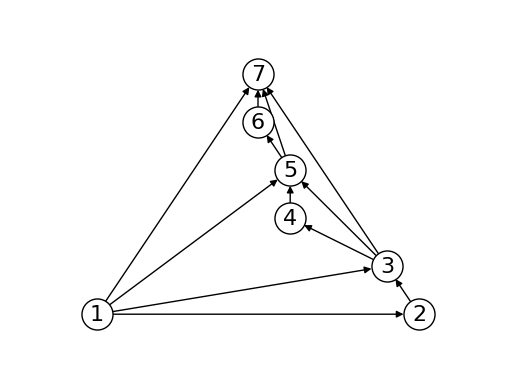

In [112]:
import networkx as nx
from matplotlib import pyplot as plt
G = nx.DiGraph()
#Add edges to the graph
for i in range(1, 7):
    G.add_edge(i, i + 1)

for i in range(1, 6, 2):
    for j in range(i + 2, 8, 2):
        G.add_edge(i, j)
#To see the graph structural overview
#For visualization
options = {
    "font_size": 16,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,

}
pos = nx.planar_layout(G)

nx.draw_networkx(G,pos,  **options) 
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [106]:
pos

{1: array([-1.        , -0.36585366]),
 2: array([ 0.70731707, -0.36585366]),
 3: array([ 0.53658537, -0.19512195]),
 4: array([ 0.02439024, -0.02439024]),
 5: array([0.02439024, 0.14634146]),
 6: array([-0.14634146,  0.31707317]),
 7: array([-0.14634146,  0.48780488])}

In [12]:
with open('/home/experiments/metrics.pickle', 'rb') as f:
    data = pickle.load(f)

In [16]:
for key in data.keys():
    print(key, data[key]['test_acc'])

darts_covtype 38.621
darts_higgs-small 47.144
darts_otto 26.05
darts_adult 76.377
darts_churn 79.65
gdas_covtype 48.76
gdas_higgs-small 47.144
gdas_otto 66.063
gdas_adult 76.377
gdas_churn 79.65
drnaso_covtype 54.375
drnaso_higgs-small 47.144
drnaso_otto 47.115
drnaso_adult 76.377
drnaso_churn 79.65


In [13]:
data

{'darts_covtype': {'train_acc': [66.14943,
   73.40391,
   77.70975,
   79.48557,
   80.79196,
   81.69347,
   82.27465,
   83.10474,
   83.59897,
   84.25546,
   84.71353,
   85.11244,
   85.53107,
   85.86425,
   86.05279,
   86.42571,
   86.65908,
   86.88767,
   87.04902,
   87.24325,
   87.40849,
   87.64126,
   87.90451,
   88.02344,
   88.11547,
   88.21199,
   88.42504,
   88.54277,
   88.63241,
   88.8105,
   88.91837,
   88.95005,
   89.05732,
   89.17744,
   89.21509,
   89.39467,
   89.44816,
   89.57485,
   89.65912,
   89.76968,
   89.83601,
   89.95404,
   89.99378,
   90.03801,
   90.13422,
   90.18472,
   90.36072,
   90.36401,
   90.47546,
   90.5666,
   90.58304,
   90.68732,
   90.77009,
   90.87437,
   90.89051,
   90.9676,
   91.05994,
   91.15167,
   91.21711,
   91.29599,
   91.31273,
   91.37906,
   91.46602,
   91.50277,
   91.61303,
   91.73793,
   91.83385,
   91.91094,
   91.87748,
   91.98176,
   92.07469,
   92.16762,
   92.20527,
   92.23007,
   92.26772